# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [8]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

acc = lambda v, v_pred: np.mean(v == v_pred)

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr_rt in learning_rates:
    for reg_st in regularization_strengths:
        svm = LinearSVM()
        hist_loss = svm.train(X_train_feats, y_train, learning_rate=lr_rt, reg=reg_st,
                      num_iters=500, verbose=False)
        
        tr_acc = np.mean(y_train == svm.predict(X_train_feats))
        val_acc = np.mean(y_val == svm.predict(X_val_feats))
        
        results[(lr_rt, reg_st)] = (tr_acc, val_acc)
        
        if (val_acc > best_val):
            best_val = val_acc
            best_svm = svm


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print("{lr} lr {reg} reg {trainacc} train accuracy: {valacc} val accuracy:".\
    format( lr = lr, reg = reg, trainacc = train_accuracy, valacc = val_accuracy))
    
print(" best validation accuracy achieved during cross-validation: {best_val}".format(best_val = best_val))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****



1e-09 lr 50000.0 reg 0.09708163265306123 train accuracy: 0.116 val accuracy:
1e-09 lr 500000.0 reg 0.08959183673469388 train accuracy: 0.097 val accuracy:
1e-09 lr 5000000.0 reg 0.09087755102040816 train accuracy: 0.08 val accuracy:
1e-08 lr 50000.0 reg 0.10548979591836735 train accuracy: 0.115 val accuracy:
1e-08 lr 500000.0 reg 0.1046734693877551 train accuracy: 0.09 val accuracy:
1e-08 lr 5000000.0 reg 0.4053673469387755 train accuracy: 0.407 val accuracy:
1e-07 lr 50000.0 reg 0.10871428571428571 train accuracy: 0.103 val accuracy:
1e-07 lr 500000.0 reg 0.41381632653061223 train accuracy: 0.416 val accuracy:
1e-07 lr 5000000.0 reg 0.3683469387755102 train accuracy: 0.363 val accuracy:
 best validation accuracy achieved during cross-validation: 0.416


In [9]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.42


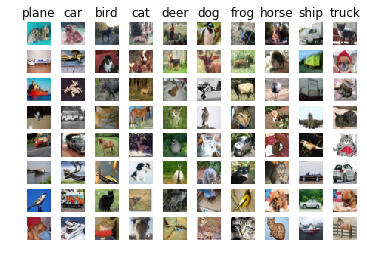

In [10]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [11]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [ ]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
input_size =  X_train_feats.shape[1]
learning_rates = [1e-3, 1e-4, 1e-5, 1e-7, 5e-7, 2e-6, 1e-8, 1e-9]
regularization_strengths = [0.05, 0.5, 1, 5, 25, 100, 5000, 1e6]
hidden_size = [10, 50, 150, 500, 1500]




acc = lambda v, v_pred: np.mean(v == v_pred)

for lr in learning_rates:
    for k in regularization_strengths:
        for h in hidden_size:
            net = TwoLayerNet(input_size, h, num_classes)
            net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=1500, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=k, verbose=True)
            y_train_pred = net.predict(X_train_feats)
            y_val_pred = net.predict(X_val_feats)
            trainbest = acc(y_train, y_train_pred)
            valbest = acc(y_val, y_val_pred)
            if valbest > best_val:
                best_val = valbest
                best_net = net
            results[(lr, k)] = (trainbest, valbest)
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print("{lr} lr {reg} reg {trainacc} train accuracy: {valacc} val accuracy:".\
    format( lr = lr, reg = reg, trainacc = train_accuracy, valacc = val_accuracy))


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


iteration 0 / 1500: loss 2.302586
iteration 100 / 1500: loss 2.302583
iteration 200 / 1500: loss 2.302566
iteration 300 / 1500: loss 2.302614
iteration 400 / 1500: loss 2.302598
iteration 500 / 1500: loss 2.302539
iteration 600 / 1500: loss 2.302550
iteration 700 / 1500: loss 2.302581
iteration 800 / 1500: loss 2.302598
iteration 900 / 1500: loss 2.302624
iteration 1000 / 1500: loss 2.302586
iteration 1100 / 1500: loss 2.302535
iteration 1200 / 1500: loss 2.302624
iteration 1300 / 1500: loss 2.302592
iteration 1400 / 1500: loss 2.302647
iteration 0 / 1500: loss 2.302587
iteration 100 / 1500: loss 2.302611
iteration 200 / 1500: loss 2.302576
iteration 300 / 1500: loss 2.302580
iteration 400 / 1500: loss 2.302562
iteration 500 / 1500: loss 2.302606
iteration 600 / 1500: loss 2.302594
iteration 700 / 1500: loss 2.302602
iteration 800 / 1500: loss 2.302565
iteration 900 / 1500: loss 2.302705
iteration 1000 / 1500: loss 2.302579
iteration 1100 / 1500: loss 2.302570
iteration 1200 / 1500: lo

iteration 300 / 1500: loss 2.302592
iteration 400 / 1500: loss 2.302582
iteration 500 / 1500: loss 2.302596
iteration 600 / 1500: loss 2.302537
iteration 700 / 1500: loss 2.302540
iteration 800 / 1500: loss 2.302488
iteration 900 / 1500: loss 2.302534
iteration 1000 / 1500: loss 2.302592
iteration 1100 / 1500: loss 2.302568
iteration 1200 / 1500: loss 2.302481
iteration 1300 / 1500: loss 2.302654
iteration 1400 / 1500: loss 2.302607
iteration 0 / 1500: loss 2.302794
iteration 100 / 1500: loss 2.302645
iteration 200 / 1500: loss 2.302604
iteration 300 / 1500: loss 2.302632
iteration 400 / 1500: loss 2.302550
iteration 500 / 1500: loss 2.302534
iteration 600 / 1500: loss 2.302596
iteration 700 / 1500: loss 2.302555
iteration 800 / 1500: loss 2.302570
iteration 900 / 1500: loss 2.302600
iteration 1000 / 1500: loss 2.302613
iteration 1100 / 1500: loss 2.302524
iteration 1200 / 1500: loss 2.302636
iteration 1300 / 1500: loss 2.302677
iteration 1400 / 1500: loss 2.302620
iteration 0 / 1500: 

D:\tdebusschere\CodeRepo\computer-vision\assignment1\cs231n\classifiers\neural_net.py:92: RuntimeWarning: overflow encountered in exp
  exp_scores = np.exp(scores)
D:\tdebusschere\CodeRepo\computer-vision\assignment1\cs231n\classifiers\neural_net.py:93: RuntimeWarning: invalid value encountered in true_divide
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
D:\tdebusschere\CodeRepo\computer-vision\assignment1\cs231n\classifiers\neural_net.py:97: RuntimeWarning: divide by zero encountered in log
  corect_logprobs = -np.log(probs[range(N), y])
D:\tdebusschere\CodeRepo\computer-vision\assignment1\cs231n\classifiers\neural_net.py:128: RuntimeWarning: invalid value encountered in greater_equal
  dy1 = dh1 * (y1 >= 0)


iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 2.504805
iteration 100 / 1500: loss nan
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 2.911090
iteration 100 / 1500: loss nan
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: l

iteration 900 / 1500: loss 2.302594
iteration 1000 / 1500: loss 2.302612
iteration 1100 / 1500: loss 2.302589
iteration 1200 / 1500: loss 2.302612
iteration 1300 / 1500: loss 2.302600
iteration 1400 / 1500: loss 2.302616
iteration 0 / 1500: loss 2.302647
iteration 100 / 1500: loss 2.302650
iteration 200 / 1500: loss 2.302646
iteration 300 / 1500: loss 2.302647
iteration 400 / 1500: loss 2.302641
iteration 500 / 1500: loss 2.302646
iteration 600 / 1500: loss 2.302647
iteration 700 / 1500: loss 2.302641
iteration 800 / 1500: loss 2.302647
iteration 900 / 1500: loss 2.302642
iteration 1000 / 1500: loss 2.302643
iteration 1100 / 1500: loss 2.302641
iteration 1200 / 1500: loss 2.302637
iteration 1300 / 1500: loss 2.302638
iteration 1400 / 1500: loss 2.302636
iteration 0 / 1500: loss 2.302790
iteration 100 / 1500: loss 2.302789
iteration 200 / 1500: loss 2.302787
iteration 300 / 1500: loss 2.302787
iteration 400 / 1500: loss 2.302778
iteration 500 / 1500: loss 2.302783
iteration 600 / 1500: 

iteration 1100 / 1500: loss 2.302590
iteration 1200 / 1500: loss 2.302594
iteration 1300 / 1500: loss 2.302592
iteration 1400 / 1500: loss 2.302591
iteration 0 / 1500: loss 2.305658
iteration 100 / 1500: loss 2.304494
iteration 200 / 1500: loss 2.303769
iteration 300 / 1500: loss 2.303329
iteration 400 / 1500: loss 2.303058
iteration 500 / 1500: loss 2.302883
iteration 600 / 1500: loss 2.302784
iteration 700 / 1500: loss 2.302710
iteration 800 / 1500: loss 2.302674
iteration 900 / 1500: loss 2.302651
iteration 1000 / 1500: loss 2.302622
iteration 1100 / 1500: loss 2.302605
iteration 1200 / 1500: loss 2.302600
iteration 1300 / 1500: loss 2.302596
iteration 1400 / 1500: loss 2.302598
iteration 0 / 1500: loss 2.312889
iteration 100 / 1500: loss 2.308987
iteration 200 / 1500: loss 2.306563
iteration 300 / 1500: loss 2.305086
iteration 400 / 1500: loss 2.304175
iteration 500 / 1500: loss 2.303600
iteration 600 / 1500: loss 2.303246
iteration 700 / 1500: loss 2.303020
iteration 800 / 1500: l

In [ ]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)